In [1]:
from scipy import ndimage as ndi

import sys
from pathlib import Path
proj = Path("../../../")
sys.path.insert(0, str(proj))
# Make "common.py" (used by simulate_inject.py) importable as a top-level module
sys.path.insert(0, str(proj / "ADCNN" / "data" / "dataset_creation"))
from torch.utils.data import DataLoader
from ADCNN.data.h5tiles import H5TiledDataset
from ADCNN.predict import load_model, predict_tiles_to_full
import ADCNN.evaluation as evaluation
from ADCNN.utils.utils import draw_one_line
import numpy as np, h5py, pandas as pd, matplotlib.pyplot as plt

In [2]:
MODEL_CKPT = "../../../checkpoints/Best/ckpt_last.pt"   # path to your trained checkpoint
TEST_H5    = "../../../DATA/test.h5"            # path to HDF5 test set with datasets: images, masks
CATALOG_CSV= "../../../DATA/test.csv"           # path to catalog (injected trails with positions & metadata)

# Tiling parameters (should match training/eval input tiling)
TILE       = 128

In [3]:
test_ds = H5TiledDataset(TEST_H5, tile=TILE, k_sigma=5.0)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)
print("Tiles:", len(test_ds), "| images:", test_ds.N, f"| panel size: {test_ds.H}x{test_ds.W}")
model = load_model(MODEL_CKPT)
p_full = predict_tiles_to_full(TEST_H5, test_loader, model, tile=TILE)
print("Predictions shape:", p_full.shape)
with h5py.File(TEST_H5, "r") as _f:
    gt_full = _f["masks"][:].astype(np.uint8)
catalog = pd.read_csv(CATALOG_CSV)

Tiles: 51200 | images: 50 | panel size: 4000x4072
Loaded model from: ../../../checkpoints/Best/ckpt_last.pt
Predictions shape: (50, 4000, 4072)


In [4]:
def two_stage_objectwise_confusion (catalog, predictions, t_low, threshold, pixel_gap=10, psf_width=40, score_method="max"):
    true_positive = 0
    false_negative = 0
    false_positive = 0
    cat = catalog.copy()

    for image_id in np.sort(catalog["image_id"].unique()):
        print (f"\rProcessing {image_id +1} / {catalog["image_id"].max()+1}", end="", flush=True)
        predicted_positive = 0
        lab, n = evaluation._label_components_fds(predictions[image_id]>=t_low, pixel_gap=pixel_gap)
        lab_predictions = np.zeros_like(predictions[image_id])
        for i in range(1, n + 1):
            comp_mask = lab == i
            if score_method == "max":
                comp_score = predictions[image_id][comp_mask].max()
            elif score_method == "topk_mean":
                vals = predictions[image_id][comp_mask]
                k = int (vals.size*0.05) if int (vals.size*0.05) > 0 else 1
                top = np.partition(vals, vals.size - k)[-k:]
                comp_score = float(top.mean())
            else:
                raise ValueError(f"Unknown score_method={score_method!r}")
            lab_predictions[comp_mask] = comp_score
            if comp_score >= threshold:
                predicted_positive += 1
        lab_predictions = lab_predictions >= threshold
        for i, row in catalog[catalog["image_id"]==image_id].iterrows():
            catalog_id = np.argwhere((catalog["x"] == row["x"]) & (catalog["y"] == row["y"]) & (catalog["image_id"] == row["image_id"]))[0][0]
            mask = draw_one_line(np.zeros((predictions.shape[1], predictions.shape[2]), dtype=np.uint8), [row["x"], row["y"]], row["beta"], row["trail_length"], true_value=1, line_thickness=int(psf_width/2))
            mask = mask != 0
            intersection = lab_predictions & mask
            lab_ids = np.unique(lab[intersection])
            lab_ids = lab_ids[lab_ids!=0]  # remove background
            lab_removed = np.isin(lab, lab_ids)
            lab_predictions[lab_removed] = 0
            if np.any(intersection):
                true_positive += 1
                cat.at[catalog_id, "nn_detected"] = True
            else:
                false_negative += 1
                cat.at[catalog_id, "nn_detected"] = False
        false_positive += max(predicted_positive - true_positive , 0)
    print ()
    return true_positive, false_positive, false_negative, cat

In [5]:
score_thrs = np.linspace(0.1, 1, 19)
rows = []
for sthr in score_thrs:
    print (f"Evaluating score_thr={sthr:.3f}", flush=True, end="")
    (tp, fp, fn, _), (_, _, f1, f2) = evaluation.pixelwise_confusion(p_full, gt_full, thr=sthr)
    rows.append((sthr, tp, fp, fn, f1, f2))
    print(f" TP={tp} FP={fp} FN={fn} F1={f1:.4f} F2={f2:.4f}")
df_px = pd.DataFrame(rows, columns=["score_thr","TP","FP","FN","F1","F2"])

Evaluating score_thr=0.100 TP=572169 FP=15483345 FN=415246 F1=0.0671 F2=0.1430
Evaluating score_thr=0.150 TP=553494 FP=10585841 FN=433921 F1=0.0913 F2=0.1834
Evaluating score_thr=0.200 TP=541160 FP=8078450 FN=446255 F1=0.1127 F2=0.2153
Evaluating score_thr=0.250 TP=533088 FP=6510192 FN=454327 F1=0.1328 F2=0.2425
Evaluating score_thr=0.300 TP=525942 FP=5438761 FN=461473 F1=0.1513 F2=0.2652
Evaluating score_thr=0.350 TP=519923 FP=4656277 FN=467492 F1=0.1687 F2=0.2849
Evaluating score_thr=0.400 TP=513276 FP=4039725 FN=474139 F1=0.1853 F2=0.3018
Evaluating score_thr=0.450 TP=507314 FP=3550284 FN=480101 F1=0.2011 F2=0.3168
Evaluating score_thr=0.500 TP=501234 FP=3142114 FN=486181 F1=0.2165 F2=0.3301
Evaluating score_thr=0.550 TP=494800 FP=2782278 FN=492615 F1=0.2321 F2=0.3423
Evaluating score_thr=0.600 TP=487698 FP=2463823 FN=499717 F1=0.2476 F2=0.3533
Evaluating score_thr=0.650 TP=478514 FP=2177735 FN=508901 F1=0.2627 F2=0.3622
Evaluating score_thr=0.700 TP=469436 FP=1919876 FN=517979 F1=0

In [6]:
rows = []
for sthr in score_thrs:
    print (f"Evaluating score_thr={sthr:.3f}", flush=True)
    tp, fp, fn, cat = two_stage_objectwise_confusion(catalog=catalog, predictions=p_full, t_low=0.1, threshold=sthr, pixel_gap=5, score_method="max")
    prec = tp / max(tp + fp, 1)
    rec  = tp / max(tp + fn, 1)
    f1   = 2 * prec * rec / max(prec + rec, 1e-12)
    f2  = 5 * tp / max(5 * tp + 4 * fn + fp, 1)
    rows.append((sthr, tp, fp, fn, prec, rec, f1, f2))
    print(f" TP={tp} FP={fp} FN={fn} P={prec:.4f} R={rec:.4f} F1={f1:.4f} F2={f2:.4f}")
df_obj = pd.DataFrame(rows, columns=["score_thr","TP","FP","FN","P","R","F1", "F2"])

Evaluating score_thr=0.100
Processing 50 / 50
 TP=659 FP=4744 FN=321 P=0.1220 R=0.6724 F1=0.2065 F2=0.3534
Evaluating score_thr=0.150
Processing 50 / 50
 TP=633 FP=1904 FN=347 P=0.2495 R=0.6459 F1=0.3600 F2=0.4902
Evaluating score_thr=0.200
Processing 50 / 50
 TP=615 FP=1117 FN=365 P=0.3551 R=0.6276 F1=0.4535 F2=0.5441
Evaluating score_thr=0.250
Processing 50 / 50
 TP=594 FP=734 FN=386 P=0.4473 R=0.6061 F1=0.5147 F2=0.5659
Evaluating score_thr=0.300
Processing 50 / 50
 TP=578 FP=501 FN=402 P=0.5357 R=0.5898 F1=0.5614 F2=0.5781
Evaluating score_thr=0.350
Processing 50 / 50
 TP=568 FP=336 FN=412 P=0.6283 R=0.5796 F1=0.6030 F2=0.5887
Evaluating score_thr=0.400
Processing 50 / 50
 TP=561 FP=215 FN=419 P=0.7229 R=0.5724 F1=0.6390 F2=0.5973
Evaluating score_thr=0.450
Processing 50 / 50
 TP=552 FP=163 FN=428 P=0.7720 R=0.5633 F1=0.6513 F2=0.5955
Evaluating score_thr=0.500
Processing 50 / 50
 TP=542 FP=132 FN=438 P=0.8042 R=0.5531 F1=0.6554 F2=0.5899
Evaluating score_thr=0.550
Processing 50 / 

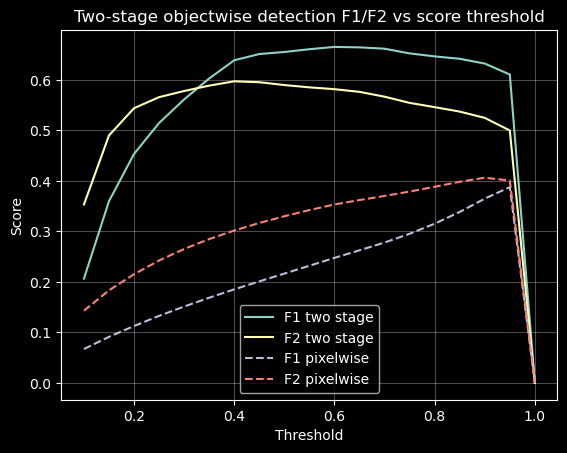

In [7]:
plt.plot(df_obj["score_thr"], df_obj["F1"], label="F1 two stage")
plt.plot(df_obj["score_thr"], df_obj["F2"], label="F2 two stage")
plt.plot(df_px["score_thr"], df_px["F1"], label="F1 pixelwise", linestyle="--")
plt.plot(df_px["score_thr"], df_px["F2"], label="F2 pixelwise", linestyle="--")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Two-stage objectwise detection F1/F2 vs score threshold")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Processing 50 / 50
{'TP_obj': 552, 'FP_cand': 163, 'FN_obj': 428, 'Precision': 0.772027972027972, 'Recall': 0.563265306122449, 'F1': 0.6513274336283186, 'F2': 0.5954692556634305}


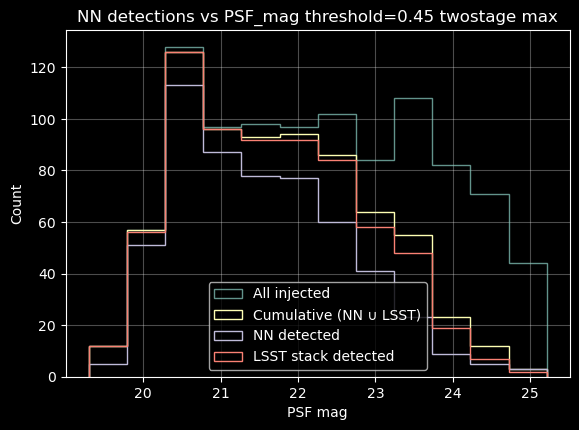

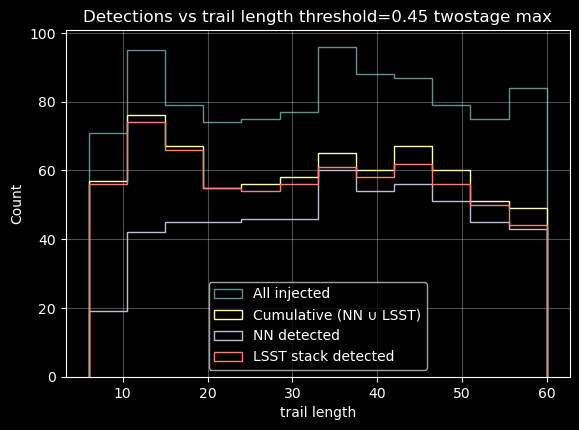

In [8]:
tp, fp, fn, cat = two_stage_objectwise_confusion(catalog=catalog, predictions=p_full, t_low=0.1, threshold=0.45, pixel_gap=5, score_method="max")
prec = tp / max(tp + fp, 1)
rec  = tp / max(tp + fn, 1)
f1   = 2 * prec * rec / max(prec + rec, 1e-12)
f2  = 5 * tp / max(5 * tp + 4 * fn + fp, 1)
print({"TP_obj": tp, "FP_cand": fp, "FN_obj": fn, "Precision": prec, "Recall": rec, "F1": f1, "F2": f2})
_ = evaluation.plot_detect_hist(cat, "PSF_mag", bins=12, title="NN detections vs PSF_mag threshold=0.45 twostage max")
_ = evaluation.plot_detect_hist(cat, "trail_length", bins=12, title="Detections vs trail length threshold=0.45 twostage max")
_ = plt.show()

In [16]:
LSST_detected = catalog["stack_detection"].to_numpy().astype(bool).sum()
NN_detected   = cat["nn_detected"].to_numpy().astype(bool).sum()
both_detected = ((catalog["stack_detection"].to_numpy().astype(bool)) | (cat["nn_detected"].to_numpy().astype(bool))).sum()
print (f"Total injected: {len(catalog)}")
print (f"LSST detected: {LSST_detected}", 100*LSST_detected/len(catalog), "%")
print (f"NN detected:   {NN_detected}", 100*NN_detected/len(catalog), "%")
print (f"Both detected: {both_detected}", 100*both_detected/len(catalog), "%")

Total injected: 980
LSST detected: 692 70.61224489795919 %
NN detected:   552 56.326530612244895 %
Both detected: 721 73.57142857142857 %
